In [1]:
import torch
import torch.nn.functional as F
%pip install torch_geometric
from torch_geometric.nn import SAGEConv
import os
import json
import os
import pickle
import json
import random
import numpy as np
from torch_geometric.data import Data
import networkx as nx
import warnings
import math
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torch.utils.data.dataloader import default_collate
from torch.utils.data import random_split

Note: you may need to restart the kernel to use updated packages.


In [2]:
def get_files_in_folder(input_folder):
    file_list = []
    for file_name in os.listdir(input_folder):
        file_path = os.path.join(input_folder, file_name)
        if os.path.isfile(file_path):
            file_list.append(file_path)
    return file_list

# Example usage:
folder_path = 'done'
verilog_files = get_files_in_folder(folder_path)
print(len(verilog_files))
print(verilog_files)

387
['done\\adder10_synth.txt', 'done\\adder11_synth.txt', 'done\\adder12_synth.txt', 'done\\adder13_synth.txt', 'done\\adder14_synth.txt', 'done\\adder15_synth.txt', 'done\\adder16_synth.txt', 'done\\adder17_synth.txt', 'done\\adder18_synth.txt', 'done\\adder19_synth.txt', 'done\\adder1_synth.txt', 'done\\adder20_synth.txt', 'done\\adder21_synth.txt', 'done\\adder22_synth.txt', 'done\\adder23_synth.txt', 'done\\adder24_synth.txt', 'done\\adder25_synth.txt', 'done\\adder26_synth.txt', 'done\\adder27_synth.txt', 'done\\adder28_synth.txt', 'done\\adder2_synth.txt', 'done\\adder3_synth.txt', 'done\\adder4_synth.txt', 'done\\adder5_synth.txt', 'done\\adder6_synth.txt', 'done\\adder7_synth.txt', 'done\\adder8_synth.txt', 'done\\adder9_synth.txt', 'done\\and10_gate_synth.txt', 'done\\and11_gate_synth.txt', 'done\\and12_gate_synth.txt', 'done\\and13_synth.txt', 'done\\and14_synth.txt', 'done\\and15_synth.txt', 'done\\and16_synth.txt', 'done\\and17_synth.txt', 'done\\and18_gate_synth.txt', 'do

In [3]:
def extracting_attributes(verilog_file):
    try:
        if os.path.isfile(verilog_file):
            with open(verilog_file, "r") as file:
                loaded_data = json.load(file)
                nodes = loaded_data[0]
                edges = loaded_data[1]
                label = loaded_data[2]
                
                x = torch.tensor(nodes, dtype=torch.float)
                edge_index = torch.tensor(edges, dtype=torch.long)
                y = torch.tensor(label, dtype=torch.float)
                num_nodes = x.size(0)
                
                # Create batch assignment vector (assuming one graph per file)
                batch = torch.zeros(num_nodes, dtype=torch.long)
                data = Data(x=x, edge_index=edge_index, y = y, batch = batch)
                return data
    
    except Exception as e:
        print(e)
        return e


In [4]:
class VerilogDataset(Dataset):  # Using Dataset from torch_geometric
    def __init__(self, verilog_files):
        print(f"Loaded {len(verilog_files)} Verilog files.")
        self.verilog_files = verilog_files

    def __len__(self):
        return len(self.verilog_files)

    def __getitem__(self, idx):
        verilog_file = self.verilog_files[idx]
        data = extracting_attributes(verilog_file)
        return data

dataset = VerilogDataset(verilog_files)
print(len(dataset))

Loaded 387 Verilog files.
387


In [5]:
print(dataset[0])
print(verilog_files[0])
print(dataset.verilog_files[0])

Data(x=[54, 7], edge_index=[2, 72], y=[1, 15], batch=[54])
done\adder10_synth.txt
done\adder10_synth.txt


In [6]:
def are_all_data_objects_unique(dataset):
    data_objects = []
    for data in dataset:
        if data in data_objects:
            return False
        data_objects.append(data)
    return True

# Example usage:
is_unique = are_all_data_objects_unique(dataset)
if is_unique:
    print("All data objects are unique.")
else:
    print("Duplicate data objects found.")


All data objects are unique.


In [7]:
y_labels = []
for data in dataset:
    # print(data)
    # print(data.y.tolist())
    y_labels.append(np.argmax(data.y.tolist()))

In [8]:
def custom_collate(batch):
    if isinstance(batch[0], Data):
        return batch
    else:
        return default_collate(batch)
    


In [9]:
X_train, X_test, y_train, y_test = train_test_split(dataset, y_labels, test_size=0.2, stratify = y_labels, random_state=41)
train_loader = DataLoader(X_train, batch_size=16, shuffle=True, collate_fn=custom_collate)
test_loader = DataLoader(X_test, batch_size=16, shuffle = False, collate_fn=custom_collate)

In [10]:
# len(train_loader.dataset)
print(train_loader.dataset[0])

Data(x=[57, 7], edge_index=[2, 69], y=[1, 15], batch=[57])


In [11]:
loader_iter = iter(train_loader)
batch = next(loader_iter)
# print(batch)
# print(batch.num_graphs)

In [13]:
from torch_geometric.nn import global_mean_pool
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        emb = self.conv2(x, edge_index)
        x = global_mean_pool(emb, batch=None)
        return x, emb


In [150]:
# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
in_channels = 7
hidden_channels = 16
out_channels = 15
model = GraphSAGE(in_channels, hidden_channels, out_channels)

# Create a simple training loop
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()


# Training the model
model.train()
for epoch in range(200):
    for data in X_train:
        optimizer.zero_grad()
        data = data.to(device)
        #forward pass
        out = model(data.x, data.edge_index)
        # print(out.shape)
        # print(data.y.shape)
        target = torch.argmax(data.y, dim=1)
        # calculate the loss
        loss = loss_fn(out, target)
        # zero the gradients of the weights so that the gradients are not accumulated
        # calculate the gradients using backpropagation
        loss.backward()
        # update the weights
        optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
        

Epoch 0, Loss: 2.7904129028320312
Epoch 10, Loss: 1.7022525072097778
Epoch 20, Loss: 1.1181812286376953
Epoch 30, Loss: 0.8820726871490479
Epoch 40, Loss: 0.6983638405799866
Epoch 50, Loss: 0.5130823254585266
Epoch 60, Loss: 0.37124955654144287
Epoch 70, Loss: 0.27920815348625183
Epoch 80, Loss: 0.19076795876026154
Epoch 90, Loss: 0.12619730830192566
Epoch 100, Loss: 0.09208124876022339
Epoch 110, Loss: 0.07312091439962387
Epoch 120, Loss: 0.05279003828763962
Epoch 130, Loss: 0.04468943923711777
Epoch 140, Loss: 0.036209896206855774
Epoch 150, Loss: 0.030864594504237175
Epoch 160, Loss: 0.0237029530107975
Epoch 170, Loss: 0.021002279594540596
Epoch 180, Loss: 0.016548868268728256
Epoch 190, Loss: 0.013550445437431335


In [154]:
train_acc = 1 - loss
train_acc

tensor(0.9892, grad_fn=<RsubBackward1>)

In [153]:
model.eval()
correct = 0
for data in X_test:
    out = model(data.x, data.edge_index)  
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    y_label = (data.y.tolist())
    y_label = y_label[0].index(1.0)
    pred_label = (pred.tolist())[0]
    # print(pred_label)
    # print(y_label)
    if y_label == pred_label:
        correct += 1            
    # correct += int((pred == data.y).sum())  # Check against ground-truth labels.
acc = correct / len(X_test)  # Derive ratio of correct predictions.

acc

0.9230769230769231

In [156]:
model.eval()
# Get node embeddings
dataset_embeddings = []
with torch.no_grad():
    for data in dataset:
        out = model(data.x, data.edge_index)  
        dataset_embeddings.append(out)


In [167]:
len(dataset_embeddings)

387

In [168]:
dataset_embeddings[0]

tensor([[  -9.9978,  -20.5545,  -21.2358,  -14.5519,  -23.7793,  -19.2123,
          -22.1409,  -17.7232,  -99.1179, -210.9078,  -81.6170,  -95.9362,
          -42.0372,  -15.8280,  -16.8025]])

In [169]:
torch.save(model.state_dict(), 'grahpSAGE98_92_200_graph_embeddings.pth')

In [19]:

graph_sage.eval()
correct = 0
for data in X_train:
    out, emb = graph_sage(data.x, data.edge_index)  
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    y_label = (data.y.tolist())
    y_label = y_label[0].index(1.0)
    pred_label = (pred.tolist())[0]
    # print(pred_label)
    # print(y_label)
    if y_label == pred_label:
        correct += 1            
    # correct += int((pred == data.y).sum())  # Check against ground-truth labels.
acc = correct / len(X_train)  # Derive ratio of correct predictions.

In [21]:
#train acc
acc

0.9352750809061489

In [15]:
in_channels = 7
hidden_channels = 16
out_channels = 15
graph_sage = GraphSAGE(in_channels, hidden_channels, out_channels)
graph_sage.load_state_dict(torch.load('grahpSAGE94_92_200_graph_embeddings.pth'))

<All keys matched successfully>

In [16]:
graph_sage.eval()
correct = 0
for data in X_test:
    out, _ = graph_sage(data.x, data.edge_index)  
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    y_label = (data.y.tolist())
    y_label = y_label[0].index(1.0)
    pred_label = (pred.tolist())[0]
    # print(pred_label)
    # print(y_label)
    if y_label == pred_label:
        correct += 1            
    # correct += int((pred == data.y).sum())  # Check against ground-truth labels.
acc = correct / len(X_test)  # Derive ratio of correct predictions.

acc

0.9230769230769231

In [17]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

graph_sage.eval()
correct = 0
prediction= []
true = []
for data in X_test:
    out, _ = graph_sage(data.x, data.edge_index)  
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    y_label = (data.y.tolist())
    y_label = y_label[0].index(1.0)
    pred_label = (pred.tolist())[0]
    # print(pred_label)
    # print(y_label)
    # if y_label == pred_label:
    #     correct += 1    
    prediction.append(pred_label)        
    true.append(y_label)
    # correct += int((pred == data.y).sum())  # Check against ground-truth labels.


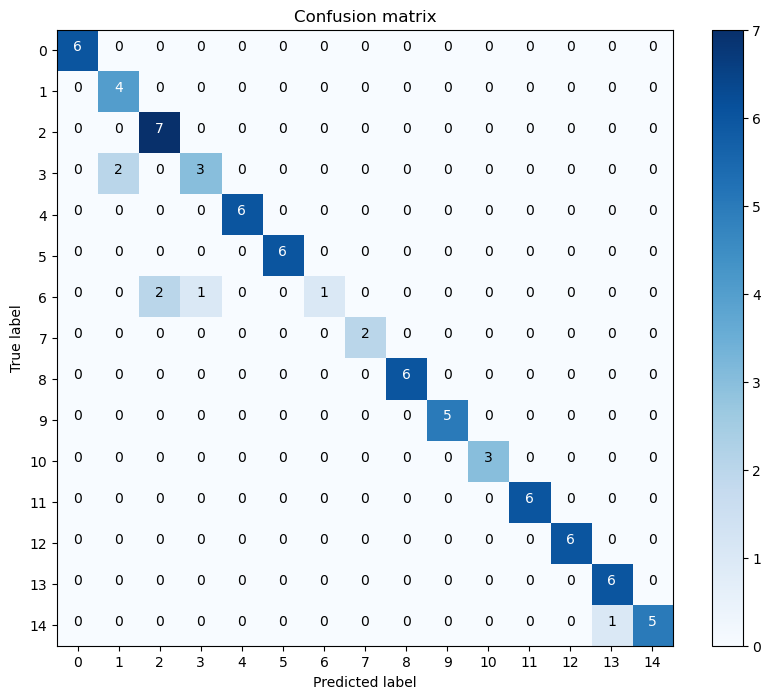

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.67      1.00      0.80         4
           2       0.78      1.00      0.88         7
           3       0.75      0.60      0.67         5
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         6
           6       1.00      0.25      0.40         4
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         6
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         6
          12       1.00      1.00      1.00         6
          13       0.86      1.00      0.92         6
          14       1.00      0.83      0.91         6

    accuracy                           0.92        78
   macro avg       0.94      0.91      0.90        78
weighted avg       0.94   

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

cm = confusion_matrix(true, prediction)

plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = range(15)
plt.xticks(tick_marks, range(15))
plt.yticks(tick_marks, range(15))
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Display confusion matrix values
for i in range(15):
    for j in range(15):
        plt.text(j, i, str(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.show()

# Print classification report for aggregate metrics
print(classification_report(true, prediction))



In [19]:
test_acc = accuracy_score(true, prediction)
print("Accuracy:", test_acc)

0.9230769230769231